### Import Libraries

In [4]:
import glob
import re
import pathlib
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import kaldiio
import numpy as np

import imblearn
import sklearn
from sklearn import datasets,metrics
from collections import Counter
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import confusion_matrix as conf
from imblearn.over_sampling import SVMSMOTE,SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

### Extract SuperVectors

In [ ]:
def uttspkdict2(FOLDER_PATH,sound_mode):
    metadata = pd.read_csv('/home/oem/Desktop/DiCOVA/DiCOVA_Track_2_Release/metadata.csv')
    spkrlist = list(metadata['ID'])
    spkrlist.sort()
    uttspk = {}
    for a in range(len(spkrlist)):
        uttspk[spkrlist[a]] = str(spkrlist[a])+"-"+sound_mode+".wav"
    return uttspk


def writeuttspk2(TEXT_PATH,dictionary,mode):
    d_keys = dictionary.keys()
    newlines = []
    for spkr in d_keys:
        utt = dictionary[spkr]
        newline = utt + ' ' + spkr        
        newlines.append(newline)
    if (mode == 'new'):
        with open(TEXT_PATH,'w') as f:
            f.write("\n".join(newlines))
    elif (mode == 'append'):
        with open(TEXT_PATH,'a') as f:
            f.write("\n")
            f.write("\n".join(newlines))
    else:
        raise ValueError('Mode Not supported')
    return 

def gettext(wavpath,asr,mode):
    if(asr == 'aspire'):
        if (mode == 'convert'):
            text = "/usr/bin/sox -t wav " + wavpath + " -c 1 -b 16 -r 8000 -t wav - |"
        elif(mode == 'direct'):
            text = wavpath
    elif(asr == 'timit'):
        if (mode == 'convert'):
            text = "/home/oem/Desktop/kaldi/egs/timit/s5/../../../tools/sph2pipe_v2.5/sph2pipe -f wav " + wavpath + " |"
        elif(mode == 'direct'):
            text = wavpath
    return text

def writescp(spkr,utt,text,dictionary,TEXT_PATH,mode):
    d_keys = dictionary.keys()
    newlines = []
    newline = spkr+'-'+utt + ' ' + text        
    newlines.append(newline)
    if (mode == 'new'):
        with open(TEXT_PATH,'w') as f:
            f.write("\n".join(newlines))
    elif (mode == 'append'):
        with open(TEXT_PATH,'a') as f:
            f.write("\n")
            f.write("\n".join(newlines))
    else:
        raise ValueError('Mode Not supported')
    return 

#### Create utt2spk and wav.scp files for aspire

In [ ]:
sound_mode = "breathing-deep"
FOLDER_PATH = "/home/oem/Desktop/DiCOVA/Coswara/"+sound_mode
sub = [ f.path for f in os.scandir(FOLDER_PATH)]
sub.sort()

"""
Run this to get utt2spk file for aspire
"""

TEXT_PATH = '/home/oem/Desktop/DiCOVA/Coswara/utt2spk'
FOLDER_PATH = "/home/oem/Desktop/DiCOVA/Coswara/"+sound_mode
my_dict = uttspkdict2(FOLDER_PATH,sound_mode)
writeuttspk2(TEXT_PATH,my_dict,'append')


"""
Run this to get the wavscp file for aspire
"""
SCP_PATH = '/home/oem/Desktop/DiCOVA/Coswara/wav.scp'
wavpathlist = []
my_dict = uttspkdict2(FOLDER_PATH,sound_mode)
metadata = pd.read_csv('/home/oem/Desktop/DiCOVA/DiCOVA_Track_2_Release/metadata.csv')
spkrlist = list(metadata['ID'])
spkrlist.sort()
for k in range(len(spkrlist)):
    spkr = spkrlist[k]
    utt = sound_mode+".wav"
    print(utt)
    print(sub[k])
    wavpathlist.append(sub[k])
    txt = gettext(wavpathlist[k],'aspire','convert')
    if(k==0):
        writescp(spkr,utt,txt,my_dict,SCP_PATH,'new')           
    else:
        writescp(spkr,utt,txt,my_dict,SCP_PATH,'append') 

#### Format the posteriors files suitable to the next code

In [ ]:
Post = "/home/oem/Desktop/DiCOVA/posteriors/"
Post_dir = Post+"counting-normal/"
post_path = "/home/oem/Desktop/DiCOVA/posteriors/combined/post4.txt"
def modposts(post_path,Post_dir)
    with open(post_path) as f:
        lines = [line.rstrip() for line in f]
    if os.path.isdir(folder):
        print("Exists")
    else:
        print("Doesn't exist")
        os.mkdir(Post_dir)

    print(len(lines))
    for i in range(len(lines)):
        x = lines[i]
        y = x[:25]+"post"
        with open(Post_dir+y,'a') as f:
            z = x
            a = z.replace(" [",",[")
            f.write(a)
    return

#### Get Posterior matrices for each utterance

In [ ]:
def findphoneindexprob(filename,phone_index):
    f0 = open(filename,'r')
    array = f0.read().split(',')
    arr_indexprob=[]
    for i in range (1,len(array)):
        s0 = array[i]
        if  ' '+str(phone_index) + ' ' in s0:
            k=0
            start = ' '+str(phone_index)+' '
            s = array[i]
            p = s.find(start)+len(start)
            for space in s[p:]:
                if (space == ' '):
                    break
                k+=1
            arr_indexprob += [float(s[s.find(start)+len(start):s.find(start)+len(start)+k])]

        else:
            arr_indexprob += [0.0]
    return arr_indexprob

def findphoneprob(filename,phone):
    with open("phonemap.txt", 'r') as document:
        phonedict = {}
        for line in document:
            line = line.split()
            phonedict[line[0]] = line[1:]
    arr_phoneprob = np.zeros(len(findphoneindexprob(filename,200))) #200 is an arbitrary non phone_index
    for i in phonedict[phone]:
        arr_phoneprob = np.add(findphoneindexprob(filename,i),arr_phoneprob)
    return arr_phoneprob

def sentenceprob(filename):
    f = open("phonenames.txt",'r')
    phonenamearray = f.read().split(',')
    y = []
    for phone in phonenamearray:
        y += [findphoneprob(filename,phone)]
    y = np.array(y)    
    return y.T

#### Get the MFCC files in npy format from the scp file

In [ ]:
PARENT_DIR = "/home/oem/Desktop/DiCOVA/Coswara"
FOLDER_PATH = "/home/oem/Desktop/DiCOVA/Coswara"
with open(FOLDER_PATH+"/feats.scp",'r') as f:
    for line in f:
        (key,rxfile) = line.split(' ')
        mfcc = kaldiio.load_mat(rxfile)
        mfcc = mfcc.mean(axis=0)
        np.save(PARENT_DIR+"/feats/breathing-deep/fbank/mfcc_avg/"+key,mfcc)

### Get the First Order statistics

In [ ]:
def fstat(spkr,output_loc,mfcc_data,postprob_data,phoneclass,threshold,start,shift,framelength):
    for key in phoneclass:
        while ((start+framelength)<=len(mfcc_data)):
            mfcc = mfcc_data[start:(start+framelength)]
            postprob = postprob_data[start:(start+framelength)]
            postprob1 = postprob[:,phoneclass[key]]
            if(np.sum(np.sum(postprob1,axis=0)) > threshold):
                phonesum = np.sum(postprob1,axis = 0)
                for k in range(0,len(phonesum)):
                    if (phonesum[k] == 0):
                        phonesum[k] = 1e-8
                norm = np.divide(postprob1,phonesum)
                vector1 = (np.dot(norm.T,mfcc))
                vector = vector1.flatten()
                np.save(output_loc+key+'/'+spkr+'_'+str(start)+'.npy',vector)                    

            start+=shift    
    return

In [ ]:
phoneclass = {'full':np.arange(0,39)}
mfcc_dir = '/home/oem/Desktop/DiCOVA/feats/mfccnew/'
mfcc = os.listdir(mfcc_dir)
mfcc.sort()
post_dir = '/home/oem/Desktop/DiCOVA/posteriors/counting-normal/'
post = os.listdir(post_dir)
post.sort()
output_loc = '/home/oem/Desktop/DiCOVA/stats/' 
for i in range(len(mfcc)):
        mfcc_data = np.load(mfcc_dir+mfcc[i])
        postprob_data = sentenceprob(post_dir+post[i])
        threshold = 0
        start = 0
        shift = len(mfcc_data)
        framelength = len(mfcc_data)
        spkr = post[i][:-5]
        fstat(spkr,output_loc,mfcc_data,postprob_data,phoneclass,threshold,start,shift,framelength)

### Get Harmonic features

In [ ]:
import csv
def makelist1(metadata_folder,audio_folder,out_folder,mode):
    md = pd.read_csv(metadata_folder+"metadata.csv")
    audio = os.listdir(audio_folder)
    audio.sort()
    
    ids = md['ID']
    line = []
    for i in range(len(audio)):
        if(ids[i]==audio[i][:8]):
            text = ids[i]+" "+audio_folder+ids[i]+"_"+mode+".wav"+" "+ out_folder+ids[i]+"_"+mode+"_harm1.txt"
            line.append(text) 
        else:
            break
        
    return line

def makelist2(metadata_folder,harm1_folder,out_folder,mode):
    md = pd.read_csv(metadata_folder+"metadata.csv")
    audio = os.listdir(audio_folder)
    audio.sort()
    
    ids = md['ID']
    line = []
    for i in range(len(audio)):
        if(ids[i]==audio[i][:8]):
            text = ids[i]+" "+harm1_folder+ids[i]+"_"+mode+"_harm1.txt"+" "+ out_folder+ids[i]+"_"+mode+"_harm2.txt"
            line.append(text) 
        else:
            break
        
    return line
    
def createtxt(array,listpath):
    with open(listpath, 'w') as f:
        for item in array:
            f.write("%s\n" % item)


In [ ]:
mode = breathing-deep
metadata_folder = "/home/oem/Desktop/DiCOVA/DiCOVA_Track_2_Release/"
audio_folder = "/home/oem/Desktop/DiCOVA/Coswara/"+mode+"/"
out_folder = "/home/oem/Desktop/DiCOVA/Coswara/feats/"+mode+"/harmonics/"
out_folder1 = out_folder+"harm_int/"
out_folder2 = out_folder+"harm/"

list1 = makelist1(metadata_folder,audio_folder,out_folder1)
list2 = makelist2(metadata_folder,out_folder1,out_folder2)
createtxt(list1,out_folder+"list1.list")
createtxt(list2,out_folder+"list2.list")

### Get Formant features

In [ ]:
import csv
def makelist1(metadata_folder,audio_folder,out_folder,mode):
    md = pd.read_csv(metadata_folder+"metadata.csv")
    audio = os.listdir(audio_folder)
    audio.sort()
    
    ids = md['ID']
    line = []
    for i in range(len(audio)):
        if(ids[i]==audio[i][:8]):
            text = ids[i]+" "+audio_folder+ids[i]+"_"+mode+".wav"+" "+ out_folder+ids[i]+"_"+mode+"_formant1.txt"
            line.append(text) 
        else:
            break
        
    return line

def makelist2(metadata_folder,harm1_folder,out_folder,mode):
    md = pd.read_csv(metadata_folder+"metadata.csv")
    audio = os.listdir(audio_folder)
    audio.sort()
    
    ids = md['ID']
    line = []
    for i in range(len(audio)):
        if(ids[i]==audio[i][:8]):
            text = ids[i]+" "+harm1_folder+ids[i]+"_"+mode+"_formant1.txt"+" "+ out_folder+ids[i]+"_"+mode+"_formant2.txt"
            line.append(text) 
        else:
            break
        
    return line
    
def createtxt(array,listpath):
    with open(listpath, 'w') as f:
        for item in array:
            f.write("%s\n" % item)


In [ ]:
mode = "counting-normal"
metadata_folder = "/home/oem/Desktop/DiCOVA/DiCOVA_Track_2_Release/"
audio_folder = "/home/oem/Desktop/DiCOVA/Coswara/"+mode+"/"
out_folder = "/home/oem/Desktop/DiCOVA/Coswara/feats/"+mode+"/harmonics/"
out_folder1 = out_folder+"harm_int/"
out_folder2 = out_folder+"harm/"

list1 = makelist1(metadata_folder,audio_folder,out_folder1,mode=mode)
list2 = makelist2(metadata_folder,out_folder1,out_folder2,mode=mode)
createtxt(list1,out_folder+"list1.list")
createtxt(list2,out_folder+"list2.list")

### Generate List Files for Train,Val and Eval

In [ ]:
def mod_metadata(metadata_path):
    metadata = pd.read_csv(metadata_path+'/metadata.csv')
    metadata = metadata.replace('p',1)
    md = metadata.replace('n',0)

    return md

def getlists(md,fstats_folder,x_folder,mode):
    fstats = os.listdir(fstats_folder)
    fstats.sort()
    if(mode=="train" or mode=="val"):
        for i in range(1,6):
            if (mode=="val"):
                file = open('/home/oem/Desktop/DiCOVA/DiCOVA_Track_2_Release/LISTS/val_fold_'+str(i)+'.txt', 'r')
            elif(mode=="train"):
                file = open('/home/oem/Desktop/DiCOVA/DiCOVA_Track_2_Release/LISTS/train_fold_'+str(i)+'.txt', 'r')
            ids = file.readlines()
            ids = [line.strip() for line in ids]
            ids.sort()
            for j in range(len(fstats)):
                fstat = fstats[j]
                ID = fstat[:8]
                for k in range(len(ids)):
                    if(ID == ids[k]):
                        fn = list(md['ID'])
                        ind = fn.index(ID)
                        label = md['Covid_status'][ind]
                        text = fstats_folder+fstat+" "+str(label)
                        if (mode=="val"):
                            with open(x_folder+"val_fold_"+str(i)+".list",'a') as listfile:
                                listfile.write(text+"\n")
                        elif(mode=="train"):
                            with open(x_folder+"train_fold_"+str(i)+".list",'a') as listfile:
                                listfile.write(text+"\n")
                                
    elif(mode=="eval"):
        file = open('/home/oem/Desktop/DiCOVA/DiCOVA_Track_2_Release/LISTS/eval_list.txt', 'r')
        ids = file.readlines()
        ids = [line.strip() for line in ids]
        ids.sort()
        for j in range(len(fstats)):
            fstat = fstats[j]
            ID = fstat[:8]
            for k in range(len(ids)):
                if(ID == ids[k]):
                    fn = list(md['ID'])
                    ind = fn.index(ID)
                    label = md['Covid_status'][ind]
                    text = fstats_folder+fstat+" "+str(label)
                    with open(x_folder+"eval_list.list",'a') as listfile:
                        listfile.write(text+"\n")
                        
    else:
        return 


In [ ]:
metadata_path = '/home/oem/Desktop/DiCOVA/DiCOVA_Track_2_Release'
fstats_folder = '/home/oem/Desktop/DiCOVA/Coswara/feats/counting-normal/fstats/full/'
x_folder = '/home/oem/Desktop/DiCOVA/Coswara/feats/counting-normal/fstats/'

In [ ]:
md = mod_metadata(metadata_path)
getlists(md,fstats_folder,x_folder,"train")
# getlists(md,fstats_folder,x_folder,"val")
# getlists(md,fstats_folder,x_folder,"eval")

### Load Train,Val and Eval features

In [1]:
def load_input1(file_path,featdim):
    with open(file_path) as f:  
        line = f.readline()
        cnt = 1
        tr = np.empty(shape=[0,featdim])
        covid_trgt = []
        while line:
            [path,rem] = line.split()
            covid = float(rem)
            data_array = np.fromfile(path)
            da = np.reshape(data_array,(1,-1))
            covid_trgt.append(covid)
            tr = np.append(tr,da,axis=0)
            line = f.readline()
            cnt+=1
        print("train shape :",np.shape(tr), "targets shape :", np.shape(covid_trgt))
    return [tr,covid_trgt]

def load_input2(file_path,featdim):
    with open(file_path) as f:  
        line = f.readline()
        cnt = 1
        tr = np.empty(shape=[0,featdim])
        covid_trgt = []
        while line:
            [path,rem] = line.split()
            covid = float(rem)
            data_array = np.load(path)
            da = np.reshape(data_array,(1,-1))
            covid_trgt.append(covid)
            tr = np.append(tr,da,axis=0)
            line = f.readline()
            cnt+=1
        print("train shape :",np.shape(tr), "targets shape :", np.shape(covid_trgt))
    return [tr,covid_trgt]

In [2]:
def data_dict1(data,feat_folder,feat_type,featdim):
    for i in range(1,6): 
        data["tr"+str(i)+"_X"],data["tr"+str(i)+"_Y"] = load_input1(feat_folder+feat_type+"/train_fold_"+str(i)+".list",featdim)

    for i in range(1,6):
        data["val"+str(i)+"_X"],data["val"+str(i)+"_Y"] = load_input1(feat_folder+feat_type+"/val_fold_"+str(i)+".list",featdim)

    data["eval_X"],data["eval_Y"] =load_input1(feat_folder+feat_type+"/eval_list.list",featdim)
    
    return data

def data_dict2(data,feat_folder,feat_type,featdim):
    for i in range(1,6): 
        data["tr"+str(i)+"_X"],data["tr"+str(i)+"_Y"] = load_input2(feat_folder+feat_type+"/train_fold_"+str(i)+".list",featdim)

    for i in range(1,6):
        data["val"+str(i)+"_X"],data["val"+str(i)+"_Y"] = load_input2(feat_folder+feat_type+"/val_fold_"+str(i)+".list",featdim)

    data["eval_X"],data["eval_Y"] =load_input2(feat_folder+feat_type+"/eval_list.list",featdim)
    
    return data

def data_dict3(data,feat_folder,feat_type,featdim):
    for i in range(1,6): 
        data["tr"+str(i)+"_X"],data["tr"+str(i)+"_Y"] = np.load("/home/oem/Desktop/DiCOVA/svm_data/counting-normal/tr"+str(i)+"_X.npy"),np.load("/home/oem/Desktop/DiCOVA/svm_data/counting-normal/tr"+str(i)+"_Y.npy")

    for i in range(1,6):
        data["val"+str(i)+"_X"],data["val"+str(i)+"_Y"] = np.load("/home/oem/Desktop/DiCOVA/svm_data/counting-normal/val"+str(i)+"_X.npy"),np.load("/home/oem/Desktop/DiCOVA/svm_data/counting-normal/val"+str(i)+"_X.npy")

    data["eval_X"],data["eval_Y"] =load_input2(feat_folder+feat_type+"/eval_list.list",featdim)
    
    return data

In [5]:
""" Counting Normal Dataset"""
feat_folder = "/home/oem/Desktop/DiCOVA/Coswara/feats/counting-normal/"

feat_type2 = "formants"
featdim2 = 30
count_form = {}
count_form = data_dict1(count_form,feat_folder,feat_type2,featdim2)

feat_type3 = "harmonics"
featdim3 = 180
count_harm = {}
count_harm = data_dict1(count_harm,feat_folder,feat_type3,featdim3)

feat_type1 = "fstats"
featdim1 = 1560
count_fstats={}
count_fstats = data_dict2(count_fstats,feat_folder,feat_type1,featdim1)

train shape : (783, 30) targets shape : (783,)
train shape : (783, 30) targets shape : (783,)
train shape : (783, 30) targets shape : (783,)
train shape : (783, 30) targets shape : (783,)
train shape : (783, 30) targets shape : (783,)
train shape : (207, 30) targets shape : (207,)
train shape : (207, 30) targets shape : (207,)
train shape : (207, 30) targets shape : (207,)
train shape : (207, 30) targets shape : (207,)
train shape : (207, 30) targets shape : (207,)
train shape : (209, 30) targets shape : (209,)
train shape : (783, 180) targets shape : (783,)
train shape : (783, 180) targets shape : (783,)
train shape : (783, 180) targets shape : (783,)
train shape : (783, 180) targets shape : (783,)
train shape : (783, 180) targets shape : (783,)
train shape : (207, 180) targets shape : (207,)
train shape : (207, 180) targets shape : (207,)
train shape : (207, 180) targets shape : (207,)
train shape : (207, 180) targets shape : (207,)
train shape : (207, 180) targets shape : (207,)
tra

In [ ]:
import pickle

# your_data = fstats

# # Store data (serialize)
# with open('/home/oem/Desktop/DiCOVA/Coswara/feats/counting-normal/fstats/fstats.pickle', 'wb') as handle:
#     pickle.dump(your_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load data (deserialize)
with open('/home/oem/Desktop/DiCOVA/Coswara/feats/counting-normal/fstats/fstats.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)
count_fstats = unserialized_data

In [6]:
""" Vowel-e Dataset"""
feat_folder = "/home/oem/Desktop/DiCOVA/Coswara/feats/vowel-e/"

feat_type1 = "formants"
featdim1 = 30
vowel_form = {}
vowel_form = data_dict1(vowel_form,feat_folder,feat_type1,featdim1)

feat_type2 = "harmonics"
featdim2 = 180
vowel_harm = {}
vowel_harm = data_dict1(vowel_harm,feat_folder,feat_type2,featdim2)

feat_type3 = "fbank"
featdim3 = 40
vowel_fbank = {}
vowel_fbank = data_dict2(vowel_fbank,feat_folder,feat_type3,featdim3)

train shape : (783, 30) targets shape : (783,)
train shape : (783, 30) targets shape : (783,)
train shape : (783, 30) targets shape : (783,)
train shape : (783, 30) targets shape : (783,)
train shape : (783, 30) targets shape : (783,)
train shape : (207, 30) targets shape : (207,)
train shape : (207, 30) targets shape : (207,)
train shape : (207, 30) targets shape : (207,)
train shape : (207, 30) targets shape : (207,)
train shape : (207, 30) targets shape : (207,)
train shape : (209, 30) targets shape : (209,)
train shape : (783, 180) targets shape : (783,)
train shape : (783, 180) targets shape : (783,)
train shape : (783, 180) targets shape : (783,)
train shape : (783, 180) targets shape : (783,)
train shape : (783, 180) targets shape : (783,)
train shape : (207, 180) targets shape : (207,)
train shape : (207, 180) targets shape : (207,)
train shape : (207, 180) targets shape : (207,)
train shape : (207, 180) targets shape : (207,)
train shape : (207, 180) targets shape : (207,)
tra

In [7]:
""" Breathing-Deep Dataset"""
feat_folder = "/home/oem/Desktop/DiCOVA/Coswara/feats/breathing-deep/"
feat_type = "formants"
featdim = 30
breath_form = {}
breath_form = data_dict1(breath_form,feat_folder,feat_type,featdim)

feat_type2 = "fbank"
featdim2 = 40
breath_fbank = {}
breath_fbank = data_dict2(breath_fbank,feat_folder,feat_type2,featdim2)

train shape : (783, 30) targets shape : (783,)
train shape : (783, 30) targets shape : (783,)
train shape : (783, 30) targets shape : (783,)
train shape : (783, 30) targets shape : (783,)
train shape : (783, 30) targets shape : (783,)
train shape : (207, 30) targets shape : (207,)
train shape : (207, 30) targets shape : (207,)
train shape : (207, 30) targets shape : (207,)
train shape : (207, 30) targets shape : (207,)
train shape : (207, 30) targets shape : (207,)
train shape : (209, 30) targets shape : (209,)
train shape : (783, 40) targets shape : (783,)
train shape : (783, 40) targets shape : (783,)
train shape : (783, 40) targets shape : (783,)
train shape : (783, 40) targets shape : (783,)
train shape : (783, 40) targets shape : (783,)
train shape : (207, 40) targets shape : (207,)
train shape : (207, 40) targets shape : (207,)
train shape : (207, 40) targets shape : (207,)
train shape : (207, 40) targets shape : (207,)
train shape : (207, 40) targets shape : (207,)
train shape :

### Class Balancing

In [ ]:
import numpy as np
from numpy import linalg as npla

def eigen(A):
    eigenValues, eigenVectors = npla.eigh(A)
    idx = np.argsort(eigenValues)[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors)

def evd(X):
    n, m = X.shape
    X = X-X.mean(axis=0)
    X[np.abs(X)<1e-10] = 0
    assert np.allclose(X.mean(axis=0), np.zeros(m))
    C = np.dot(X.T, X) / (n)
    eig_vals, eig_vecs = eigen(C)
    eig_vals[np.real(eig_vals)<1e-10]=0.0
    sing_vals = np.sqrt(eig_vals)
    return eig_vals,sing_vals,eig_vecs

def gen_coeffs(eigen_vals):
    samples = []
    samples = [np.random.normal(scale = eigen_vals[i]) for i in range(len(eigen_vals))]
    return samples

def get_new_samples(q,eigen_vecs):
    s = np.zeros(len(q))
    for i in range(len(q)):
        s+=q[i]*eigen_vecs[:,i]
    return s

def get_new_minority_samples(major_samples,minor_samples,sample_count):
    X1 = major_samples
    X2 = minor_samples
    n,m = X1.shape
    samples = np.zeros((sample_count,m))
    mean = X2.mean(axis=0)
    eig_vals,sing_vals,eig_vecs=evd(X1)
    for i in range(sample_count):
        q = gen_coeffs(eig_vals)
        s = get_new_samples(q,eig_vecs)
        s+=mean
        samples[i]+=s
    
    return samples

def balance_dist(X,y,sample_count):
    y = np.array(y)
    counter = Counter(y)
    id_neg = np.where(y==0)[0]
    id_pos = np.where(y==1)[0]
    y_pos =y[id_pos]
    X_pos = X[id_pos]
    X_neg = X[id_neg]
    y_neg =y[id_neg]
    new_pos = get_new_minority_samples(X_neg,X_pos,sample_count)
    X_pos = np.concatenate((X_pos,new_pos))
    y_pos = np.concatenate((y_pos,np.ones(sample_count)))
    X = np.concatenate((X_pos,X_neg))
    y = np.concatenate((y_pos,y_neg))
#     idx = np.random.permutation(len(y))
    idx = np.random.RandomState(seed=42).permutation(len(y))

    X,y = X[idx],y[idx]
    
    return X,y

### PCA

In [ ]:
def dimred(train_X,val_X):
    pca = PCA(300)
    pca.fit(train_X)
    train_X = pca.transform(train_X)
    val_X = pca.transform(val_X)
    return train_X,val_X

def run_dimred(data):
    folds = list(data.keys())
    for i in range(0,(len(folds)-2)//2,2):
        data[folds[i]],data[folds[i+10]]=dimred(data[folds[i]],data[folds[i+10]])
    
    return data

### Classifier

In [8]:
def score_auc(estimator, X, y):
    y_score = estimator.decision_function(X)  # You could also use the binary predict, but probabilities should give you a more realistic score.
    probs = y_score
    return y_score,roc_auc_score(y, probs)

def sens_spec(Conf):
    sens = (Conf[1][1])/(Conf[1][1]+Conf[1][0])
    spec = (Conf[0][0])/(Conf[0][1]+Conf[0][0])
    return sens,spec

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

def compute_eer(fpr,tpr,thresholds):
    fnr = 1-tpr
#     eer_threshold=thresholds[np.argmax(np.sqrt(tpr*(1-fpr)))]
    eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
    return eer_threshold

def SVM(train_X,train_Y,val_X,val_Y,C):
    clf = svm.SVC(C=C,class_weight="balanced",probability=True)
    clf.fit(train_X,train_Y)
    probs = clf.decision_function(val_X)
#     probs = (probs-np.min(probs))/(np.max(probs)-np.min(probs))
    probs = 1/(1+np.exp(-1*probs))
    return probs

def SVM1(train_X,train_Y,val_X,val_Y,C):
    clf = svm.SVC(C=C,class_weight="balanced",probability=True)
    clf.fit(train_X,train_Y)
    probs = clf.predict_proba(val_X)
    return probs

In [9]:
def run_SVM_CV(data,C,pred,balance=False):
    y_hard={}
    folds = list(data.keys())
    for i in range(0,(len(folds)-2)//2,2):
        if (balance==False):
            print("Folds:",i//2+1)
            y_prob = SVM(data[folds[i]],data[folds[i+1]],data[folds[i+10]],data[folds[i+11]],C)
            fpr, tpr, t = metrics.roc_curve(data[folds[i+11]], y_prob)
            auc = metrics.auc(fpr,tpr)
#             best_thresh = score(data[folds[i+11]],y_prob)
            best_thresh =compute_eer(fpr,tpr,t) 
            hard = to_labels(y_prob,best_thresh)
            confusion = conf(data[folds[i+11]],hard)
            sens,spec = sens_spec(confusion)
            print("Sens:",sens,"Spec:",spec)
            print("auc:",auc)
            pred["pred_fold_"+str((i//2+1))] = y_prob
            y_hard["hard_fold_"+str((i//2+1))] = hard
        else:
            X,Y = balance_dist(data[folds[i]],data[folds[i+1]],700)
            y_prob = SVM(X,Y,data[folds[i+10]],data[folds[i+11]],C)
            pred["pred_fold_"+str((i//2+1))] = y_prob
    return y_hard,pred

In [10]:
def run_SVM_eval(data,C,balance=False):
    folds = list(data.keys())
    if (balance==False):
        tr_X = np.concatenate((data[folds[0]],data[folds[10]]))
        tr_Y = np.concatenate((data[folds[1]],data[folds[11]]))
        val_X,val_Y = data[folds[20]],data[folds[21]]
        y_prob = SVM(tr_X,tr_Y,val_X,val_Y,C)

    return val_Y,y_prob

In [11]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1

    sens = TP/(TP+FN)
    return sens


def score(testy,probs):
    thresholds = np.arange(-1, 1, 0.001)
    scores = [perf_measure(testy, to_labels(probs, t)) for t in thresholds]
    scores = np.subtract(scores,[0.8]*len(scores))
    ix = np.argmin(np.abs(scores))
    print(scores)
    best_thresh = thresholds[ix]
    return best_thresh
    
def sens_eighty(fpr,tpr,thresholds):
    abs_diffs = np.argwhere(tpr==0.8)
    min_index=abs_diffs
    best_thresh = thresholds[min_index]
    return best_thresh


def avg_CV(data,data_soft):
    folds = list(data.keys())
    fds = list(data_soft.keys())
    y_true = np.concatenate([data[folds[i+11]] for i in range(0,(len(folds)-2)//2,2)])
    probs = np.concatenate([data_soft[fds[j]] for j in range(0,5)])
    fpr, tpr, thresholds = metrics.roc_curve(y_true, probs)
    auc = metrics.auc(fpr,tpr)
#     best_thresh = score(y_true,probs)
    best_thresh = compute_eer(fpr,tpr,thresholds)
    hard = to_labels(probs,best_thresh)
    confusion = conf(y_true,hard)
    sens,spec = sens_spec(confusion)
    print("Sens:",sens,"Spec:",spec)
    print("auc:",auc)
#     print(confusion)
    
    return hard,best_thresh




def avg_eval(data,best_thresh,C,feat,data_type):
    y_true,probs = run_SVM_eval(data,C)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, probs)
    thresh = compute_eer(fpr,tpr,thresholds)
    auc = metrics.auc(fpr,tpr)
    hard = to_labels(probs,best_thresh)
    confusion = conf(y_true,hard)
    sens,spec = sens_spec(confusion)
    print("Sens:",sens,"Spec:",spec)
    print("auc:",auc)
    print(confusion)
    plot_roc(y_true,probs,feat,data_type)
    return probs,hard

## MAKE PREDICTIONS!

### Counting-Normal

In [12]:
count_fstats_soft={}
count_form_soft={}
count_harm_soft={}

count_fstats_hard={}
count_form_hard={}
count_harm_hard={}

C: 0.2
Folds: 1
Sens: 0.6190476190476191 Spec: 0.6182795698924731
auc: 0.6426011264720942
Folds: 2
Sens: 0.5714285714285714 Spec: 0.543010752688172
auc: 0.6490015360983103
Folds: 3
Sens: 0.6190476190476191 Spec: 0.7043010752688172
auc: 0.6433691756272402
Folds: 4
Sens: 0.7142857142857143 Spec: 0.6989247311827957
auc: 0.6651305683563747
Folds: 5
Sens: 0.6666666666666666 Spec: 0.6559139784946236
auc: 0.7037890424987199
Sens: 0.638095238095238 Spec: 0.6376344086021506
auc: 0.6544188428059396
Sens: 0.7142857142857143 Spec: 0.5691489361702128
auc: 0.6474164133738602
[[107  81]
 [  6  15]]


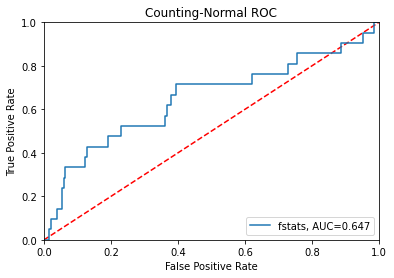

In [17]:
C=[0.2]
for j in range(len(C)):
    print("C:",C[j])
    count_fstats_hard,count_fstats_soft = run_SVM_CV(count_fstats,C[j],count_fstats_soft,balance=False)
    x,count_fstats_thresh = avg_CV(count_fstats,count_fstats_soft)
count_fstats_eval_soft,count_fstats_eval_hard=avg_eval(count_fstats,count_fstats_thresh,C[0],feat="fstats",data_type="Counting-Normal")

C: 10.0
Folds: 1
Sens: 0.6666666666666666 Spec: 0.6451612903225806
auc: 0.7204301075268817
Folds: 2
Sens: 0.5714285714285714 Spec: 0.5860215053763441
auc: 0.6379928315412187
Folds: 3
Sens: 0.6190476190476191 Spec: 0.6290322580645161
auc: 0.6451612903225806
Folds: 4
Sens: 0.6190476190476191 Spec: 0.6344086021505376
auc: 0.6164874551971327
Folds: 5
Sens: 0.5714285714285714 Spec: 0.521505376344086
auc: 0.6113671274961597
Sens: 0.6095238095238096 Spec: 0.6086021505376344
auc: 0.6408602150537636
Sens: 0.5238095238095238 Spec: 0.6542553191489362
auc: 0.6519756838905775
[[123  65]
 [ 10  11]]


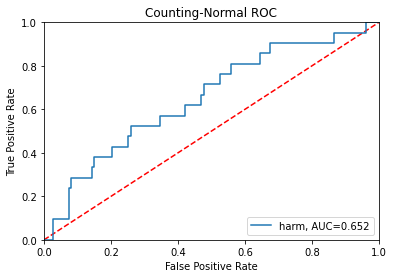

In [18]:
C=[1e1]
for j in range(len(C)):
    print("C:",C[j])
    count_harm_hard,count_harm_soft = run_SVM_CV(count_harm,C[j],count_harm_soft,balance=False)
    x,count_harm_thresh = avg_CV(count_harm,count_harm_soft)
count_harm_eval_soft,count_harm_eval_hard=avg_eval(count_harm,count_harm_thresh,C[0],feat="harm",data_type="Counting-Normal")

C: 10.0
Folds: 1
Sens: 0.6666666666666666 Spec: 0.6612903225806451
auc: 0.7621607782898105
Folds: 2
Sens: 0.6666666666666666 Spec: 0.6881720430107527
auc: 0.6715309779825909
Folds: 3
Sens: 0.6190476190476191 Spec: 0.6129032258064516
auc: 0.6344086021505376
Folds: 4
Sens: 0.6190476190476191 Spec: 0.6021505376344086
auc: 0.631336405529954
Folds: 5
Sens: 0.5714285714285714 Spec: 0.5752688172043011
auc: 0.6643625192012288
Sens: 0.6285714285714286 Spec: 0.6258064516129033
auc: 0.666041986687148
Sens: 0.7142857142857143 Spec: 0.6170212765957447
auc: 0.6973150962512664
[[116  72]
 [  6  15]]


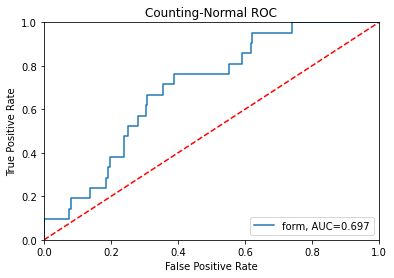

In [19]:
C=[1e1]
for j in range(len(C)):
    print("C:",C[j])
    count_form_hard,count_form_soft = run_SVM_CV(count_form,C[j],count_form_soft,balance=False)
    x,count_form_thresh = avg_CV(count_form,count_form_soft)
    
count_form_eval_soft,count_form_eval_hard=avg_eval(count_form,count_form_thresh,C[0],feat="form",data_type="Counting-Normal")

In [20]:
vowel_form_soft = {}
vowel_harm_soft = {}
vowel_fbank_soft = {}

vowel_form_hard = {}
vowel_harm_hard = {}
vowel_fbank_hard = {}

C: 3500
Folds: 1
Sens: 0.6190476190476191 Spec: 0.6129032258064516
auc: 0.6776753712237583
Folds: 2
Sens: 0.5714285714285714 Spec: 0.5860215053763441
auc: 0.631336405529954
Folds: 3
Sens: 0.6190476190476191 Spec: 0.6344086021505376
auc: 0.6187916026625703
Folds: 4
Sens: 0.6666666666666666 Spec: 0.6666666666666666
auc: 0.6963645673323093
Folds: 5
Sens: 0.47619047619047616 Spec: 0.4946236559139785
auc: 0.5307219662058371
Sens: 0.6 Spec: 0.6021505376344086
auc: 0.6317255504352279
Sens: 0.5714285714285714 Spec: 0.5159574468085106
auc: 0.6005572441742655
[[97 91]
 [ 9 12]]


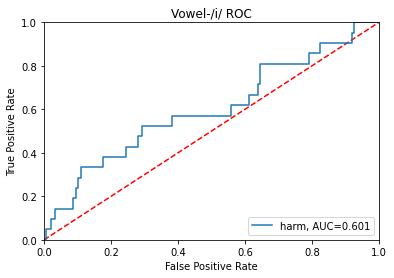

In [21]:
C=[3500]
for j in range(len(C)):
    print("C:",C[j])
    vowel_harm_hard,vowel_harm_soft = run_SVM_CV(vowel_harm,C[j],vowel_harm_soft,balance=False)
    x,vowel_harm_thresh = avg_CV(vowel_harm,vowel_harm_soft)
vowel_harm_eval_soft,vowel_harm_eval_hard=avg_eval(vowel_harm,vowel_harm_thresh,C[0],feat="harm",data_type="Vowel-/i/")

C: 0.5
Folds: 1
Sens: 0.5714285714285714 Spec: 0.5860215053763441
auc: 0.6564260112647209
Folds: 2
Sens: 0.5714285714285714 Spec: 0.5268817204301075
auc: 0.6664106502816179
Folds: 3
Sens: 0.7142857142857143 Spec: 0.7365591397849462
auc: 0.721710189452125
Folds: 4
Sens: 0.5714285714285714 Spec: 0.5752688172043011
auc: 0.6131592421915003
Folds: 5
Sens: 0.5238095238095238 Spec: 0.5161290322580645
auc: 0.558115719406042
Sens: 0.5904761904761905 Spec: 0.5741935483870968
auc: 0.6317972350230414
Sens: 0.5714285714285714 Spec: 0.5957446808510638
auc: 0.5901722391084093
[[112  76]
 [  9  12]]


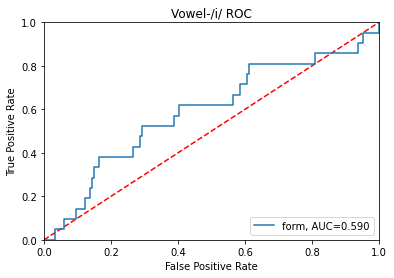

In [22]:
C=[0.5]
for j in range(len(C)):
    print("C:",C[j])
    vowel_form_hard,vowel_form_soft = run_SVM_CV(vowel_form,C[j],vowel_form_soft,balance=False)
    x,vowel_form_thresh = avg_CV(vowel_form,vowel_form_soft)
vowel_form_eval_soft,vowel_form_eval_hard = avg_eval(vowel_form,vowel_form_thresh,C[0],feat="form",data_type="Vowel-/i/")

C: 1
Folds: 1
Sens: 0.6666666666666666 Spec: 0.6720430107526881
auc: 0.7178699436763952
Folds: 2
Sens: 0.6190476190476191 Spec: 0.6505376344086021
auc: 0.6833077316948285
Folds: 3
Sens: 0.6666666666666666 Spec: 0.6774193548387096
auc: 0.7327188940092165
Folds: 4
Sens: 0.6190476190476191 Spec: 0.6397849462365591
auc: 0.655657962109575
Folds: 5
Sens: 0.6190476190476191 Spec: 0.6182795698924731
auc: 0.6400409626216078
Sens: 0.6476190476190476 Spec: 0.6494623655913978
auc: 0.6874859190988224
Sens: 0.47619047619047616 Spec: 0.6223404255319149
auc: 0.6030901722391084
[[117  71]
 [ 11  10]]


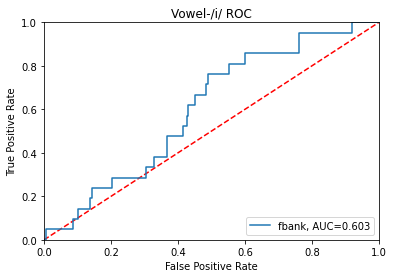

In [23]:
C=[1]
for j in range(len(C)):
    print("C:",C[j])
    vowel_fbank_hard,vowel_fbank_soft = run_SVM_CV(vowel_fbank,C[j],vowel_fbank_soft,balance=False)
    x,vowel_fbank_thresh = avg_CV(vowel_fbank,vowel_fbank_soft)
vowel_fbank_eval_soft,vowel_fbank_eval_hard=avg_eval(vowel_fbank,vowel_fbank_thresh,C[0],feat="fbank",data_type="Vowel-/i/")

In [24]:
breath_form_soft={}
breath_form_hard={}
breath_fbank_soft={}
breath_fbank_hard={}

C: 30
Folds: 1
Sens: 0.5714285714285714 Spec: 0.5806451612903226
auc: 0.6129032258064515
Folds: 2
Sens: 0.5714285714285714 Spec: 0.532258064516129
auc: 0.5890937019969278
Folds: 3
Sens: 0.5238095238095238 Spec: 0.5698924731182796
auc: 0.6298003072196621
Folds: 4
Sens: 0.5714285714285714 Spec: 0.5376344086021505
auc: 0.6349206349206349
Folds: 5
Sens: 0.5238095238095238 Spec: 0.4838709677419355
auc: 0.5873015873015873
Sens: 0.5714285714285714 Spec: 0.5720430107526882
auc: 0.6086635944700461
Sens: 0.5714285714285714 Spec: 0.5
auc: 0.6127152988855116
[[94 94]
 [ 9 12]]


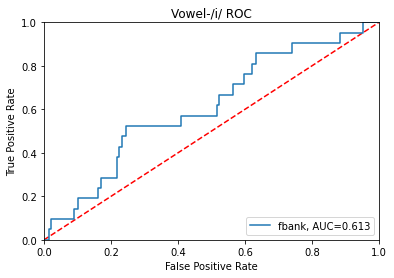

In [25]:
C=[30]
for j in range(len(C)):
    print("C:",C[j])
    breath_fbank_hard,breath_fbank_soft = run_SVM_CV(breath_fbank,C[j],breath_fbank_soft,balance=False)
    x,breath_fbank_thresh = avg_CV(breath_fbank,breath_fbank_soft)
breath_fbank_eval_soft,breath_fbank_eval_hard=avg_eval(breath_fbank,breath_fbank_thresh,C[0],feat="fbank",data_type="Vowel-/i/")

C: 1
Folds: 1
Sens: 0.6666666666666666 Spec: 0.6666666666666666
auc: 0.7114695340501792
Folds: 2
Sens: 0.6190476190476191 Spec: 0.5967741935483871
auc: 0.5911418330773169
Folds: 3
Sens: 0.6666666666666666 Spec: 0.6451612903225806
auc: 0.7268305171530978
Folds: 4
Sens: 0.6190476190476191 Spec: 0.6505376344086021
auc: 0.6746031746031746
Folds: 5
Sens: 0.6190476190476191 Spec: 0.553763440860215
auc: 0.6863799283154122
Sens: 0.6095238095238096 Spec: 0.6172043010752688
auc: 0.6736815156169994
Sens: 0.5714285714285714 Spec: 0.7553191489361702
auc: 0.7018743667679838
[[142  46]
 [  9  12]]


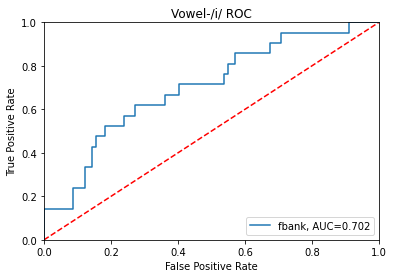

In [26]:
C=[1]
for j in range(len(C)):
    print("C:",C[j])
    breath_form_hard,breath_form_soft = run_SVM_CV(breath_form,C[j],breath_form_soft,balance=False)
    x,breath_form_thresh = avg_CV(breath_form,breath_form_soft)
breath_form_eval_soft,breath_form_eval_hard=avg_eval(breath_form,breath_form_thresh,C[0],feat="fbank",data_type="Vowel-/i/")

In [14]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

def plot_roc(y_test,preds,feat,data_type):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title(data_type+' ROC')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.plot(fpr, tpr, label = feat+', AUC=%0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    return

In [15]:
def auc_avg_CV(data,data_pred,feat,data_type):
    folds = list(data.keys())
    fds = list(data_pred.keys())
    X = np.concatenate([data[folds[i+11]] for i in range(0,(len(folds)-2)//2,2)])
    Y = np.concatenate([data_pred[fds[j]] for j in range(0,5)])
    plot_roc(X,Y,feat,data_type)
    return
def auc_eval(data,pred,feat,data_type):
    folds = list(data.keys())
    X = data[folds[21]]
    Y = pred
    plot_roc(X,Y,feat,data_type)
    return

def avg_CV_eval(data,pred,feat,data_type):
    folds = list(data.keys())
    X = data[folds[21]]
    Y = pred
#     confusion = conf(X,Y)
#     sens,spec = sens_spec(confusion)
#     print("Sens:",sens,"Spec:",spec)
#     print(confusion)
    plot_roc(X,Y,feat,data_type)
    return

def avg_CV1(data,data_pred,feat,data_type):
    folds = list(data.keys())
    fds = list(data_pred.keys())
    X = np.concatenate([data[folds[i+11]] for i in range(0,(len(folds)-2)//2,2)])
    Y = np.concatenate([data_pred[fds[j]] for j in range(0,5)])
#     confusion = conf(X,Y)
#     auc = metrics.auc(X,Y)
    fpr, tpr, thresholds = metrics.roc_curve(X,Y)
    auc = metrics.auc(fpr,tpr)
#     sens,spec = sens_spec(confusion)
#     print("Sens:",sens,"Spec:",spec)
#     print(confusion)
    print("AUC:",auc)
    plot_roc(X,Y,feat,data_type)
    return auc

def avg_CV2(data,data_soft,C):
    folds = list(data.keys())
    fds = list(data_pred.keys())
    X = np.concatenate([data[folds[i+11]] for i in range(0,(len(folds)-2)//2,2)])
    Y = np.concatenate([data_soft[fds[j]] for j in range(0,5)])
    probs = Y
    fpr, tpr, thresholds = metrics.roc_curve(X, probs)
    auc = metrics.auc(fpr,tpr)
    J = tpr-fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    probs = to_labels(probs,best_thresh)
    confusion = conf(X,probs)
    sens,spec = sens_spec(confusion)
    print("Sens:",sens,"Spec:",spec)
    print("auc:",auc)
#     print(confusion)
    
    return best_thresh

In [ ]:
data_type = 'Counting-Normal'
auc_avg_CV(count_fstats,count_fstats_soft,feat='supervectors_CV',data_type=data_type)
auc_eval(count_fstats,count_fstats_eval_soft,feat='supervectors_eval',data_type=data_type)
auc_avg_CV(count_form,count_form_soft,feat='formants_CV',data_type=data_type)
auc_eval(count_form,count_form_eval_soft,feat='formants_eval',data_type=data_type)
auc_avg_CV(count_harm,count_harm_soft,feat='harmonics_CV',data_type=data_type)
auc_eval(count_harm,count_harm_eval_soft,feat='harmonics_eval',data_type=data_type)

In [ ]:
data_type = 'Vowel-/i/'
auc_avg_CV(vowel_fbank,vowel_fbank_soft,feat='fbank_CV',data_type=data_type)
auc_eval(vowel_fbank,vowel_fbank_eval_soft,feat='fbank_eval',data_type=data_type)

auc_avg_CV(vowel_form,vowel_form_soft,feat='formants_CV',data_type=data_type)
auc_eval(vowel_form,vowel_form_eval_soft,feat='formants_eval',data_type=data_type)

auc_avg_CV(vowel_harm,vowel_harm_soft,feat='harmonics_CV',data_type=data_type)
auc_eval(vowel_harm,vowel_harm_eval_soft,feat='harmonics_eval',data_type=data_type)

In [ ]:
data_type = 'Breathing-Deep'
auc_avg_CV(breath_form,breath_form_soft,feat='formants_CV',data_type=data_type)
auc_eval(breath_form,breath_form_eval_soft,feat='formants_eval',data_type=data_type)
auc_avg_CV(breath_fbank,breath_fbank_soft,feat='fbank_CV',data_type=data_type)
auc_eval(breath_fbank,breath_fbank_eval_soft,feat='fbank_eval',data_type=data_type)

In [16]:
def run_maxvoting(data1,data2,data3):
    pred={}
    folds = list(data2.keys())
#     print(folds[0])
    for i in range(len(folds)):
        pred1 = data1[folds[i]]
        pred2 = data2[folds[i]]
        pred3 = data3[folds[i]]
        pred[folds[i]] = (data1[folds[i]]+data2[folds[i]]+data3[folds[i]])
    return pred

def run_maxvoting2(data1,data2,data3,data4,data5,data6):
    pred={}
    folds = list(data2.keys())
#     print(folds[0])
    for i in range(len(folds)):
        pred1 = data1[folds[i]]
        pred2 = data2[folds[i]]
        pred3 = data3[folds[i]]
        pred4 = data4[folds[i]]
        pred5 = data5[folds[i]]
        pred6 = data6[folds[i]]
        pred[folds[i]] = (pred1+pred2+pred3+pred4+pred5+pred6)/6
    return pred


def run_maxvoting1(data1,data2):
    pred={}
    folds = list(data1.keys())
    for i in range(len(folds)):
        pred1 = data1[folds[i]]
        pred2 = data2[folds[i]]
        pred[folds[i]] = (pred1+pred2)/2
        
    return pred

def run_maxvoting_eval1(data1,data2,data3):
    pred = (data1+data2+data3)
    return pred

def run_maxvoting_eval2(data1,data2):
    pred = (data1+data2)/2
    return pred

def run_maxvoting_eval(data1,data2,data3,data4,data5,data6):
    pred = (data1+data2+data3+data4+data5+data6)/6
    return pred

def threshold(pred):
    folds = list(pred.keys())
    for i in range(len(folds)):
        a = pred[folds[i]]
        a[a<3] = 0
        a[a>3] = 1
        a[a==3] = np.random.choice([0,1])
        pred[folds[i]] = a
    return pred

def thresh2(pred):
    folds = list(pred.keys())
    for i in range(len(folds)):
        a = pred[folds[i]]
        a[a<=1] = 0
        a[a>1] = 1
        pred[folds[i]] = a
        
    return pred

def thresh_eval(t,pred):
    a = pred
    a[a<t] = 0
    a[a>t] = 1
    a[a==t] = np.random.choice([0,1])
    
    pred = a
        
    return pred

def thresh_eval1(pred):
    a = pred
    a[a<=1] = 0
    a[a>1] = 1
    
    pred = a
        
    return pred

def maxvote1(hard1,hard2,hard3):
    pred={}
    pred = run_maxvoting(hard1,hard2,hard3)
    fds = list(pred.keys())
    x = pred
#     for i in range(1,6):
#         print(conf(vowel_fbank["val"+str(i)+"_Y"],x[fds[i-1]]))
        
    return x

def maxvote3(hard1,hard2):
    pred={}
    pred = run_maxvoting1(hard1,hard2)
    fds = list(pred.keys())
    x = pred
#     for i in range(1,6):
#         print(conf(vowel_fbank["val"+str(i)+"_Y"],x[fds[i-1]]))
        
    return x

def maxvote2(hard1,hard2,hard3,hard4,hard5,hard6):
    pred={}
    pred = run_maxvoting2(hard1,hard2,hard3,hard4,hard5,hard6)
    fds = list(pred.keys())
#     x = threshold(pred)
#     for i in range(1,6):
#         print(conf(vowel_fbank["val"+str(i)+"_Y"],x[fds[i-1]]))
    x = pred
        
    return x

def maxvote_eval1(hard1,hard2,hard3):
    pred = run_maxvoting_eval1(hard1,hard2,hard3)
#     x = thresh_eval1(pred)
    x = pred
    return x

def maxvote_eval3(hard1,hard2):
    pred = run_maxvoting_eval2(hard1,hard2)
#     x = thresh_eval1(pred)
    x = pred
    return x

def maxvote_eval(hard1,hard2,hard3,hard4,hard5,hard6):
    pred = run_maxvoting_eval(hard1,hard2,hard3,hard4,hard5,hard6)
#     x = thresh_eval(3,pred)
    x = pred
    return x

def avgCV_vote(hard1,hard2,hard3,hard4,hard5):
    pred={}
    pred = run_maxvoting(hard1,hard2,hard3)
    fds = list(pred.keys())

AUC: 0.6817716333845366


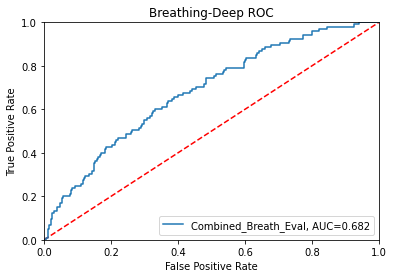

In [27]:
x1 = maxvote1(vowel_form_soft,vowel_harm_soft,vowel_fbank_soft)
conf1 = avg_CV1(vowel_form,x1,feat="Combined_Breath_Eval",data_type="Breathing-Deep")

AUC: 0.6683563748079877


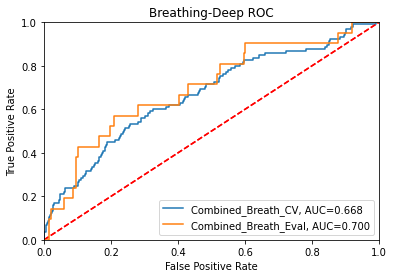

In [28]:
x7 = maxvote3(breath_form_soft,breath_fbank_soft)
conf7 = avg_CV1(breath_form,x7,feat="Combined_Breath_CV",data_type = "Breathing-Deep")
x8 = maxvote_eval3(breath_form_eval_soft,breath_fbank_eval_soft)
conf8 = avg_CV_eval(breath_form,x8,feat="Combined_Breath_Eval",data_type="Breathing-Deep")

In [ ]:
x2 = maxvote1(count_form_soft,count_harm_soft,count_fstats_soft)
conf2 = avg_CV1(count_harm,x2,feat="Combined_Breath_Eval",data_type="Breathing-Deep")

AUC: 0.7373067076292883


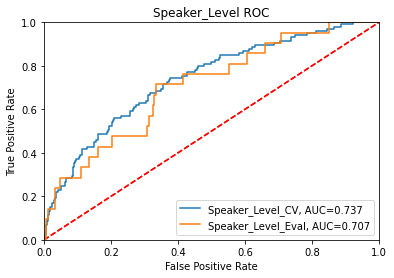

In [29]:
x3 = maxvote2(vowel_form_soft,vowel_fbank_soft,breath_form_soft,breath_fbank_soft,count_form_soft,count_fstats_soft)
conf3 = avg_CV1(vowel_form,x3,feat="Speaker_Level_CV",data_type="Speaker_Level")
x5 = maxvote_eval(vowel_form_eval_soft,vowel_fbank_eval_soft,breath_form_eval_soft,breath_fbank_eval_soft,count_form_eval_soft,count_fstats_eval_soft)
conf5 = avg_CV_eval(vowel_form,x5,feat="Speaker_Level_Eval",data_type="Speaker_Level")

In [31]:
vowel_form_eval_soft

array([0.49913335, 0.27129419, 0.41147918, 0.64325878, 0.28754331,
       0.51250532, 0.28799735, 0.22146228, 0.34172776, 0.71909844,
       0.31235336, 0.41570678, 0.41543357, 0.27851114, 0.45981784,
       0.53246666, 0.34130536, 0.49712356, 0.38235031, 0.40990057,
       0.34987018, 0.29082287, 0.21488057, 0.30161955, 0.49729872,
       0.55588269, 0.18795956, 0.29474686, 0.63570523, 0.32378347,
       0.37495862, 0.21358695, 0.24414644, 0.46973697, 0.50282528,
       0.19046382, 0.56639975, 0.39209771, 0.58831907, 0.63692583,
       0.64834912, 0.50976116, 0.40823923, 0.56474234, 0.24112797,
       0.57919156, 0.65541974, 0.43531984, 0.49804433, 0.19470314,
       0.29487668, 0.33940354, 0.52592541, 0.58230427, 0.47793343,
       0.52201206, 0.45944317, 0.5280875 , 0.28722125, 0.47147215,
       0.20057983, 0.54150086, 0.3223813 , 0.3681097 , 0.4574097 ,
       0.62600992, 0.37019473, 0.2619476 , 0.49632983, 0.25435763,
       0.46542807, 0.3902692 , 0.14476743, 0.24191336, 0.53176

In [ ]:
x4 = maxvote_eval1(vowel_form_eval_soft,vowel_harm_eval_soft,vowel_fbank_eval_soft)
conf4 = avg_CV_eval(vowel_form,x4,feat="Combined",data_type='vowel-e')

In [ ]:
x6 = maxvote_eval1(count_fstats_eval_soft,count_form_eval_soft,count_harm_eval_soft)
conf6 = avg_CV_eval(count_harm,x6,feat="Combined",data_type='counting-normal')

In [ ]:
x6 = maxvote_eval1(count_fstats_eval_hard,count_form_eval_hard,count_harm_eval_hard)
conf6 = avg_CV_eval(count_harm,x6,feat="Combined",data_type='counting-normal')